In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Load Data

In [2]:
df = pd.read_csv('heart.csv')
print("First 5 rows:\n", df.head())
print("\nInfo:")
df.info()

First 5 rows:
    Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------

# 2. Data Cleaning

In [3]:
print("\nMissing values:\n", df.isna().sum())
df = df.drop_duplicates()
print(f"\nShape after dropping duplicates: {df.shape}")


Missing values:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Shape after dropping duplicates: (918, 12)


# Check for irrelevant columns

In [4]:
print(f"\nColumns: {df.columns.tolist()}")


Columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


# Convert categorical columns to category

In [5]:
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in categorical_cols:
    df[col] = df[col].astype('category')


# Encode categorical variables (One-Hot Encoding)

In [6]:
df_encoded = pd.get_dummies(df, drop_first=True)

# 3. EDA

In [7]:
print("\nDescribe:\n", df_encoded.describe())


Describe:
               Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  


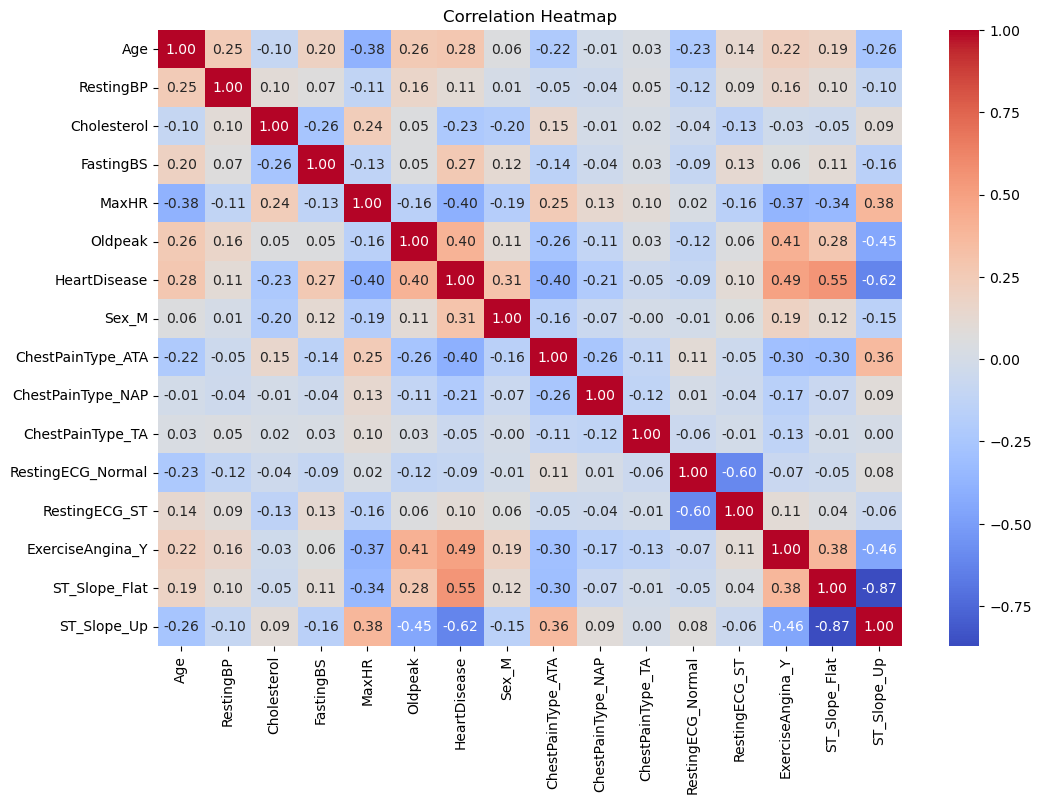

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

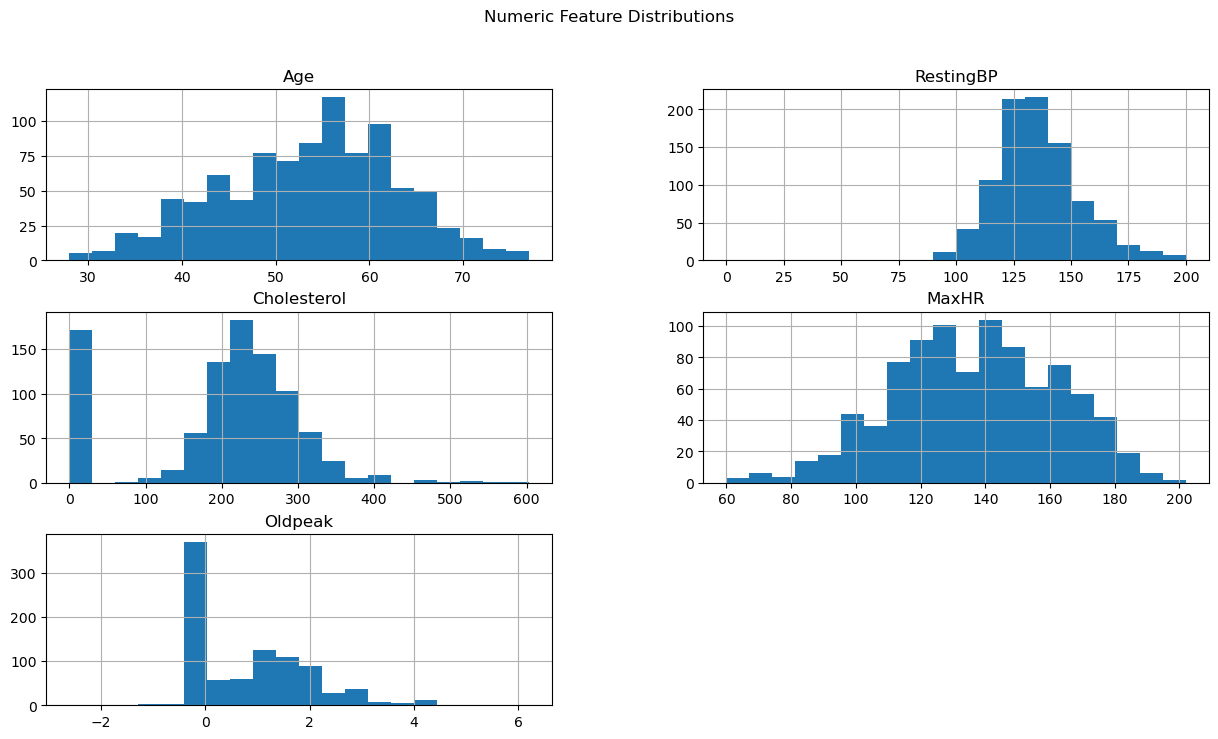

In [9]:
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[numeric_cols].hist(bins=20, figsize=(15, 8))
plt.suptitle("Numeric Feature Distributions")
plt.show()

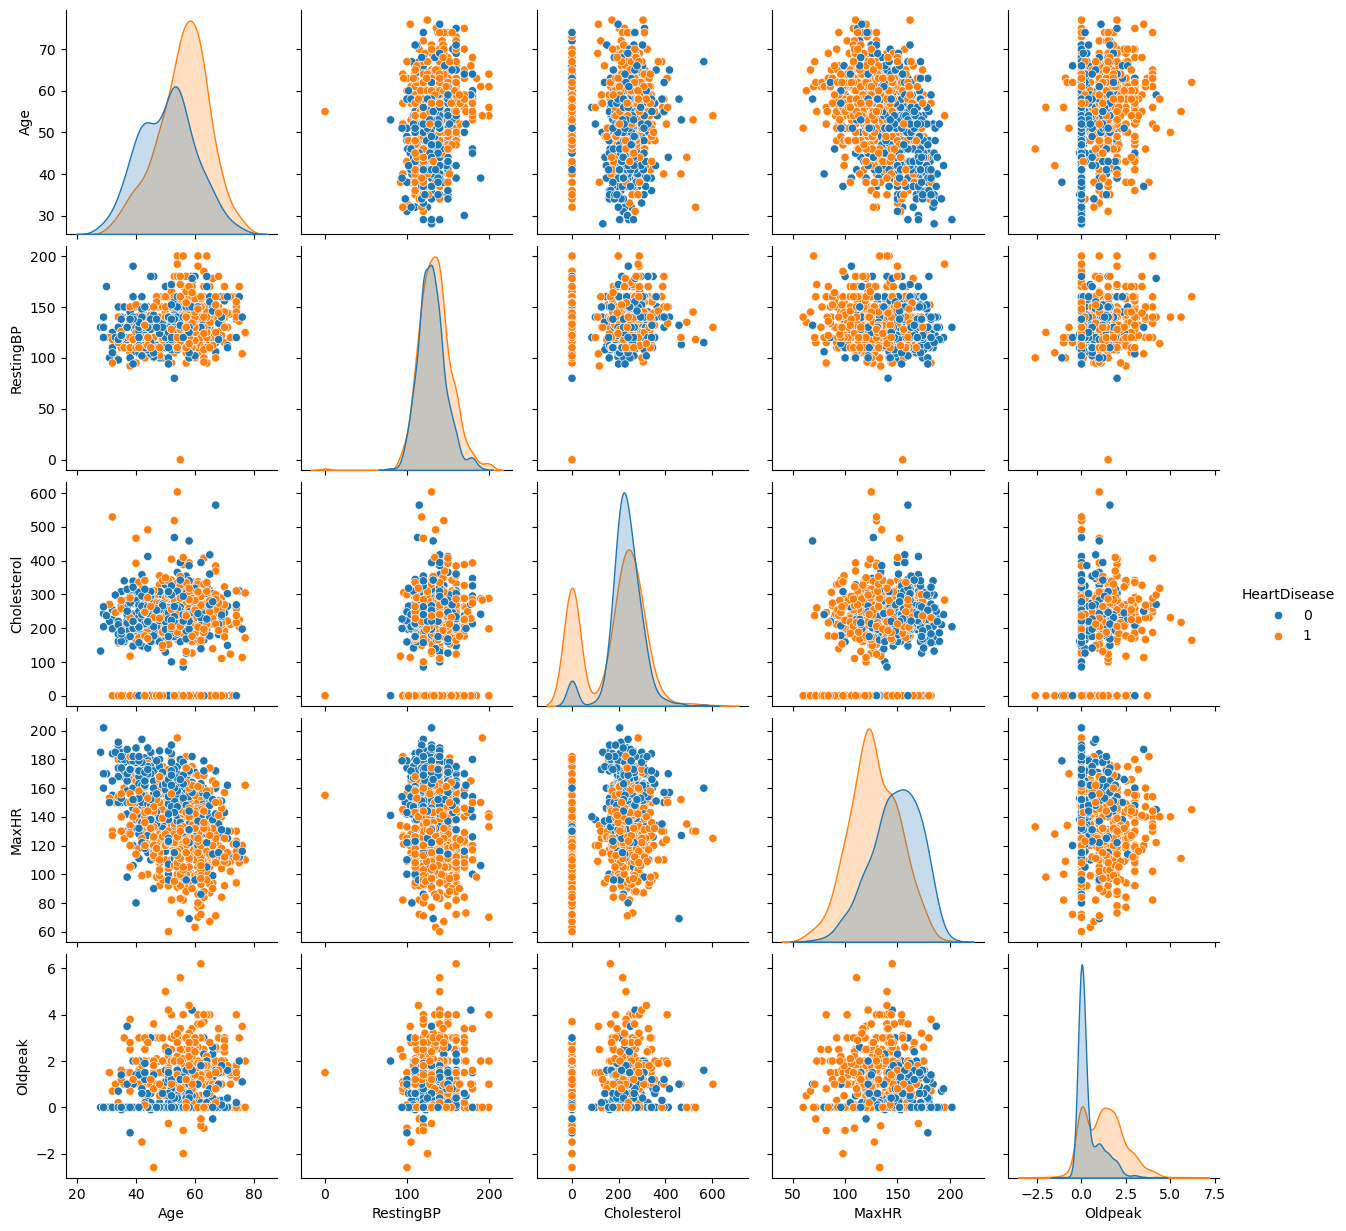

In [10]:
sns.pairplot(df, hue='HeartDisease', vars=numeric_cols)
plt.show()

# 4. Feature Engineering: Log-transform skewed features

In [11]:
skewed = ['Cholesterol', 'Oldpeak']
for col in skewed:
    df_encoded[col] = np.log1p(df_encoded[col])

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 5. Prepare Data


In [12]:
target = 'HeartDisease'
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

# Scale features

In [17]:
# Replace inf/-inf with NaN, then fill NaN with column mean
X_clean = X.replace([np.inf, -np.inf], np.nan)
X_clean = X_clean.fillna(X_clean.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Split


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# 6. Model Training (Linear Regression)


In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# 7. Evaluation

In [20]:
print("\nLinear Regression Results:")
print("R2 Score: ", r2_score(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))


Linear Regression Results:
R2 Score:  0.5491161331302337
MAE:  0.25135687224261594
MSE:  0.10972448544246236
RMSE:  0.3312468648039742


# Feature importance

In [21]:
print("\nFeature coefficients:")
for name, coef in zip(X.columns, lr.coef_):
    print(f"{name}: {coef:.4f}")


Feature coefficients:
Age: 0.0199
RestingBP: 0.0022
Cholesterol: -0.0756
FastingBS: 0.0419
MaxHR: -0.0149
Oldpeak: 0.0535
Sex_M: 0.0591
ChestPainType_ATA: -0.0756
ChestPainType_NAP: -0.0806
ChestPainType_TA: -0.0293
RestingECG_Normal: -0.0139
RestingECG_ST: -0.0189
ExerciseAngina_Y: 0.0824
ST_Slope_Flat: 0.0724
ST_Slope_Up: -0.1116


# 8. Visualization: Predictions vs Actual

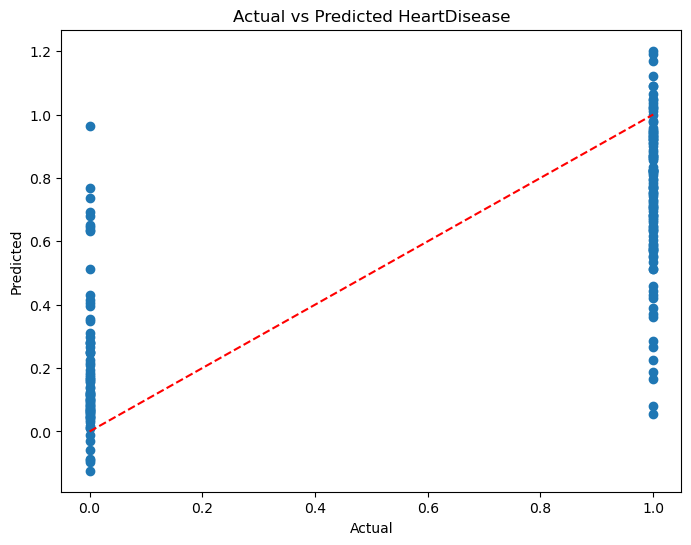

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted HeartDisease")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Residuals


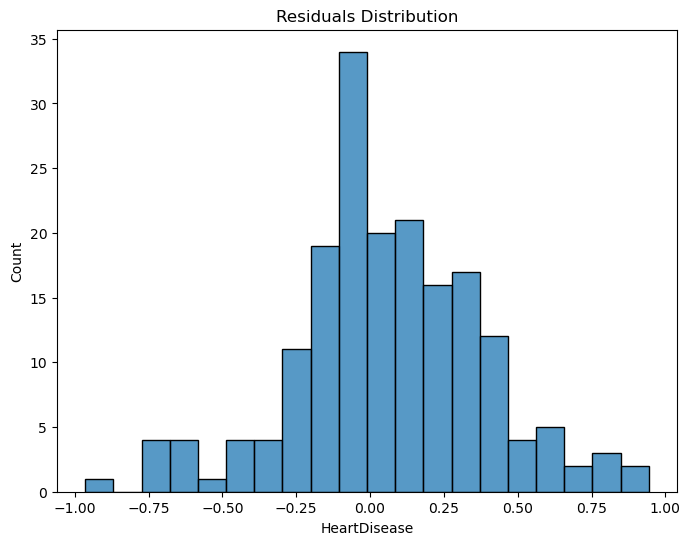

In [23]:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=20)
plt.title("Residuals Distribution")
plt.show()